In [45]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Data from Social Competition Task
[Download dataset](http://neurotycho.brain.riken.jp/download/base/20100803S1_Social+Competition_K2_Toru+Yanagawa_csv_ECoG128-Eye9-Motion22-Event3.zip)

In [46]:
data = pd.read_csv('../data/Eye-Motion/ECoG.csv', header=0)

In [47]:
data_sample = data[:100]

In [48]:
data_sample = data_sample.loc[:, :"ECoG_ch6"]

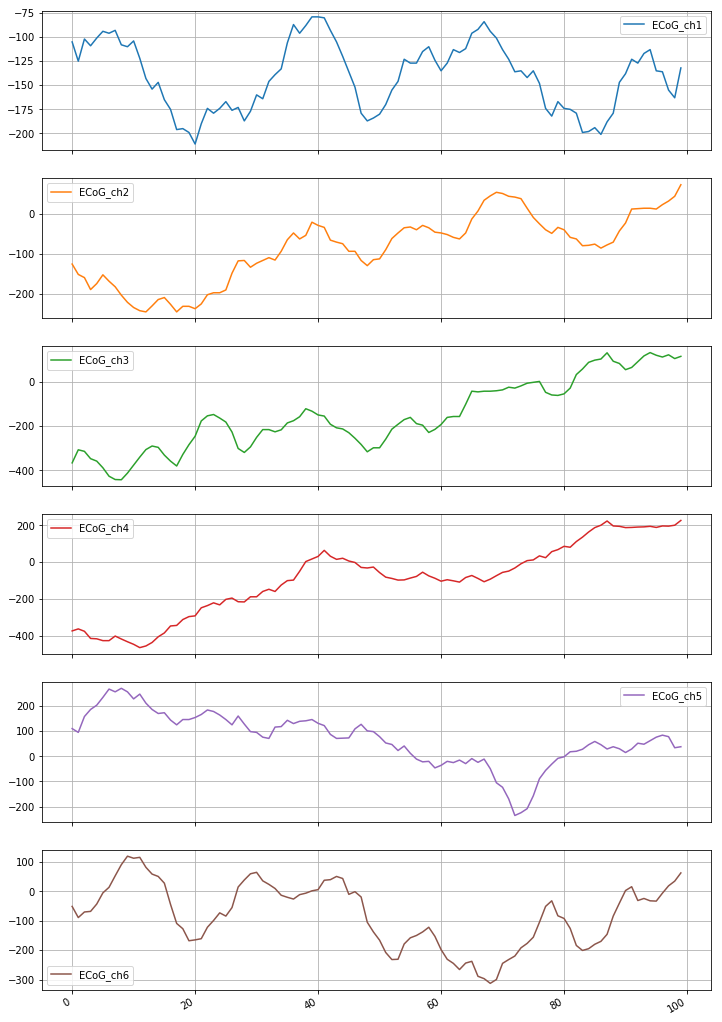

In [49]:
%matplotlib inline
data_sample.loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(12, 20), grid=True);